In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sklearn
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tools import *
datadir = '/'.join(os.getcwd().split('/')[:-1])+"/2_Data/"

import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)


In [2]:
raw = pd.read_csv(datadir+'train.csv')
meta_df = pd.read_csv(datadir+'building_metadata.csv')

In [3]:
@logger
def select_meter(df, meter=0):
    return df[df.meter==0].drop(columns=['meter'])

@logger
def drop_outliers(df, threshold=5000):
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [4]:
df = (raw.pipe(start_pipeline)
         .pipe(reduce_mem_usage)
         .pipe(select_meter)
         .pipe(drop_outliers)   
         .pipe(to_datetime)
     )
     
meta_df = (pd.read_csv(datadir+'building_metadata.csv').pipe(start_pipeline)
                                                       .pipe(reduce_mem_usage))
           
weather_df = (pd.read_csv(datadir+'weather_train.csv').pipe(start_pipeline)
                                                      .pipe(reduce_mem_usage))

# keep households
meta_df = meta_df[meta_df.primary_use == 'Lodging/residential']

start_pipeline took 0:00:00 secs, shape(20216100, 4)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(20216100, 4)
select_meter took 0:00:00 secs, shape(12060910, 3)
drop_outliers took 0:00:00 secs, shape(12049079, 3)
to_datetime took 0:00:00 secs, shape(12049079, 3)
start_pipeline took 0:00:00 secs, shape(1449, 6)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
reduce_mem_usage took 0:00:00 secs, shape(1449, 6)
start_pipeline took 0:00:00 secs, shape(139773, 9)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(139773, 9)


In [5]:
#df.set_index('timestamp', inplace=True)
df = df.set_index('building_id').join(meta_df.set_index('building_id'), how='inner')
# drop columns
df = df.drop(columns=['floor_count', 'year_built'])
#df.set_index('timestamp', inplace=False)
# keep households
df = df[df.primary_use == 'Lodging/residential']

site_id_to_keep = df.site_id.unique()
weather_df = weather_df[weather_df.site_id.isin(site_id_to_keep)]

In [6]:
df = df.set_index('timestamp').join(weather_df.set_index('timestamp'), how='inner', lsuffix='left')

In [7]:
df.isna().sum()

meter_reading               0
site_idleft                 0
primary_use                 0
square_feet                 0
site_id                     0
air_temperature          7462
cloud_coverage        6700862
dew_temperature          9196
precip_depth_1_hr     3610705
sea_level_pressure    1465761
wind_direction         844999
wind_speed              43076
dtype: int64

In [8]:
# drop columns
df = df.drop(columns=['site_idleft', 'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'primary_use'])
df = df.dropna(axis=0)


In [43]:
df_small = df.sample(frac=0.1)

In [45]:
df_small['week'] = df_small.index.week
df_small['day'] =  df_small.index.weekday

# Feature Selection

We extracted the day of the week and week features from the timestamp. Intuitively power consumption should change in households during weekends, and for example vacation weeks. We one hot encode these features as well as the site_id feature. We scaled the rest of the features by subtracting the mean and dividing by the standard deviation.

In [46]:
# prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df_small[x]) for x in ["week", "day"]], axis=1)
X_site_id = pd.get_dummies(df_small.site_id)
X_rest = df_small.drop(columns=['meter_reading', 'site_id', 'week', 'day'])
#scale X_rest
X_rest -= X_rest.mean()
X_rest /= X_rest.std()


In [47]:
X = np.concatenate([X_time, X_site_id, X_rest], axis=1)
print(X.shape)

(1464600, 76)


In [48]:
y = df_small.meter_reading.values
mean = y.mean()
std = y.std()
y = (y- mean)/std

# Baseline Model 

For comparison we trained a Ridge regression model, to be used as our baseline.

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [50]:


X_train, X_test, y_train, y_test   = train_test_split(X, y)


In [51]:
lr = Ridge()
lr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [91]:
y_hat = lr.predict(X_test)
# convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.669
MAE: 68.046
RMSE: 102.456
R2: 0.447


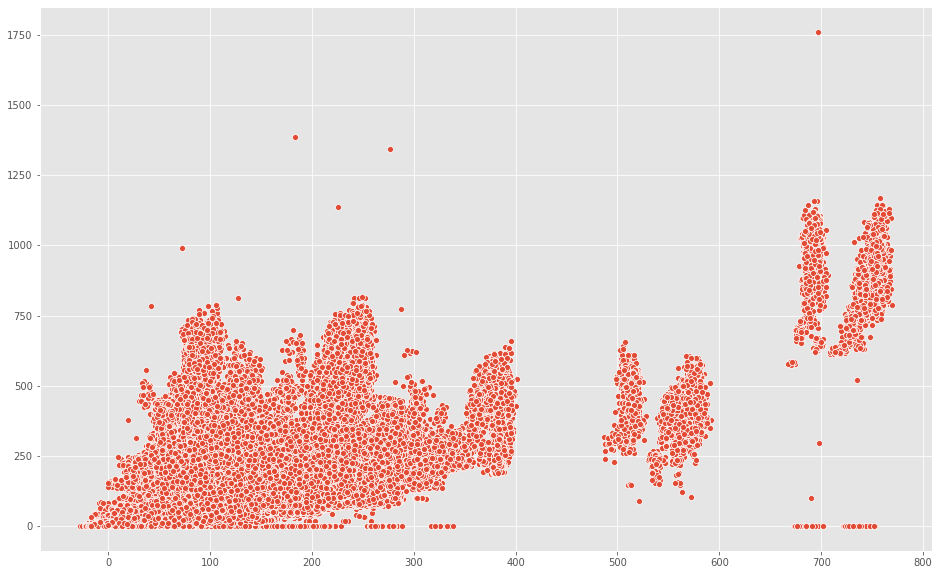

In [100]:
sns.scatterplot(preds, y_true)

# Pyro Model

## Bayesian Linear Regression

In [93]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 5.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            5.*torch.ones(X.shape[1])))    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [94]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [95]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [96]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 3465186.3
[100] ELBO: 3468085.3
[200] ELBO: 3171845.1
[300] ELBO: 3071083.4
[400] ELBO: 2841582.3
[500] ELBO: 2771756.5
[600] ELBO: 2904854.5
[700] ELBO: 2670189.1
[800] ELBO: 2637240.3
[900] ELBO: 2651863.4
[1000] ELBO: 2477869.5
[1100] ELBO: 2559063.7
[1200] ELBO: 2349312.2
[1300] ELBO: 2638739.6
[1400] ELBO: 2081420.2
[1500] ELBO: 1617288.0
[1600] ELBO: 2105874.2
[1700] ELBO: 1799089.5
[1800] ELBO: 2054615.9
[1900] ELBO: 2241410.3
[2000] ELBO: 1994844.4
[2100] ELBO: 1846864.9
[2200] ELBO: 1833030.1
[2300] ELBO: 1591321.1
[2400] ELBO: 1880025.7
[2500] ELBO: 1554014.1
[2600] ELBO: 1770697.4
[2700] ELBO: 1383031.9
[2800] ELBO: 1365257.8
[2900] ELBO: 1338630.0
[3000] ELBO: 1364518.0
[3100] ELBO: 1298129.9
[3200] ELBO: 1311040.3
[3300] ELBO: 1314332.9
[3400] ELBO: 1290390.3
[3500] ELBO: 1287906.4
[3600] ELBO: 1264824.8
[3700] ELBO: 1305118.6
[3800] ELBO: 1266347.0
[3900] ELBO: 1323766.8


In [97]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [98]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples.T), axis=1)

# convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.668
MAE: 68.509
RMSE: 102.590
R2: 0.446


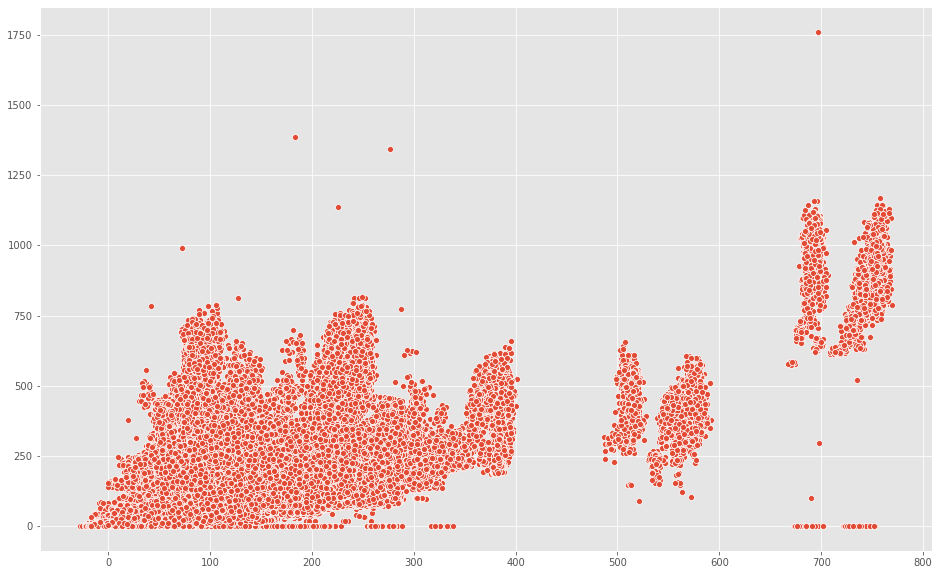

In [99]:
sns.scatterplot(preds, y_true)